In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import random
import datetime as dt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from scipy import stats
import collections
from collections import Counter
from scipy.stats import spearmanr
#plot
from matplotlib.colors import DivergingNorm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_day
import config_origins_chapter0 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
#choose method to run the script on
name_method = 'ML-method'
#name_method = 'TD-method'

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
pal_zone = config.pal_zone
pal_pens = config.pal_pens
dico_pen_ts = config.dico_pen_ts
pal_tracking_system = config.pal_tracking_system
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')  
path_extracted_data_cleaning_rawvscleaned = os.path.join(path_extracted_data_cleaning,'Raw&Cleaned')  
path_extracted_data_cleaning_rawvscleaned_MLP = os.path.join(path_extracted_data_cleaning_rawvscleaned, 'MLP')
if not os.path.exists(path_extracted_data_cleaning_rawvscleaned_MLP):
    os.makedirs(path_extracted_data_cleaning_rawvscleaned_MLP)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [5]:
df_var = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_daily_ALL_variables.csv'), sep=';', 
                 parse_dates=['level'], dayfirst=True) 
print(df_var.shape)
df_var['tracking_system'] = df_var['PenID'].map(lambda x: dico_pen_ts[x])
df_var['PenID'] = df_var['PenID'].map(lambda x: 'Pen '+str(int(x)))
#keep days with same artificial light (not that due to technical issue, sometimes we loose few hours on specific days for 
#some animals, thus we will remove these)
df_var = df_var[df_var['verification_daily_total_duration']==54000]
print(df_var.shape)
print('You are analysing %d days'%len(df_var['level'].unique()))
df_var.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19992, 126)
(17460, 127)
You are analysing 57 days


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,temperature_night20_2_median,temperature_night20_2_max,temperature_night20_2_var,list_of_MovementCounter_day,len_MovementCounter_day,MovementCounter_day_amount_nnactivity,MovementCounter_day_max,MovementCounter_day_mean,type,tracking_system
1,hen_131,2020-11-14,405.0,17084.0,23716.0,2512.0,10283.0,54000.0,"[405.0, 17084.0, 23716.0, 2512.0, 10283.0]","[0.0075, 0.31637037037037036, 0.43918518518518...",...,26.0,28.0,0.750000,"[14.0, 69.0, 47.0, 79.0, 50.0, 46.0, 64.0, 75....",90.0,0.011111,95.0,59.077778,cleaning,TrackingSystem 10-12
2,hen_131,2020-11-15,0.0,16576.0,28684.0,2187.0,6553.0,54000.0,"[0.0, 16576.0, 28684.0, 2187.0, 6553.0]","[0.0, 0.30696296296296294, 0.5311851851851852,...",...,28.0,29.0,0.098765,"[16.0, 70.0, 57.0, 55.0, 60.0, 65.0, 73.0, 73....",90.0,0.033333,91.0,57.922222,cleaning,TrackingSystem 10-12
3,hen_131,2020-11-16,0.0,14508.0,29621.0,3091.0,6780.0,54000.0,"[0.0, 14508.0, 29621.0, 3091.0, 6780.0]","[0.0, 0.26866666666666666, 0.548537037037037, ...",...,27.0,28.0,0.693673,"[64.0, 23.0, 75.0, 52.0, 75.0, 48.0, 52.0, 58....",90.0,0.022222,94.0,54.944444,cleaning,TrackingSystem 10-12


In [6]:
np.nanmean(df_var['Total_number_transition'].tolist()), np.nanmedian(df_var['Total_number_transition'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(66.06884306987399, 64.0)

# Initial visuals

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


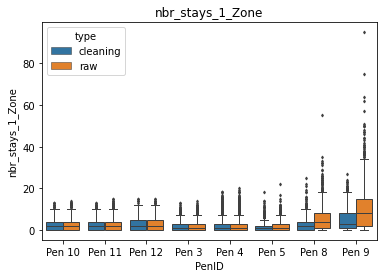

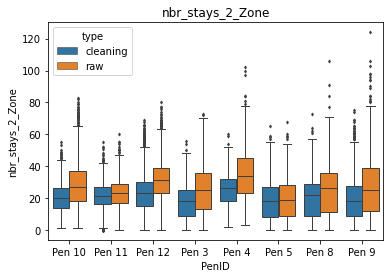

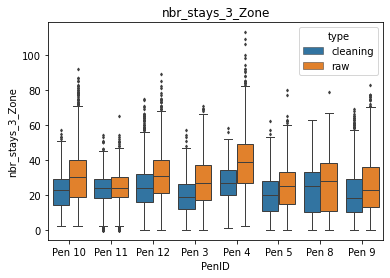

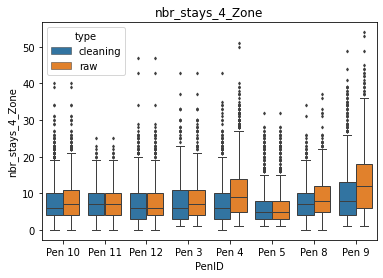

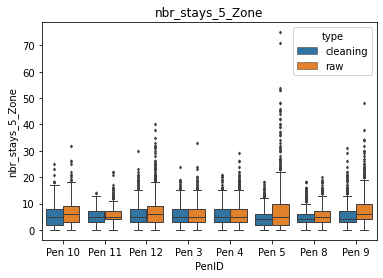

In [7]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_var:
    sns.boxplot(x='PenID', y=v, hue='type', data=df_var, fliersize=2, linewidth=1)
    plt.title(v)
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_perPen_'+v+".png"),
            dpi=300,format='png',bbox_inches='tight')
    plt.show()

# humidity bias?

(5157, 13)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


(1586818, 7)


,HenID,PenID,system,Zone,prediction,Timestamp,date
0,hen_19,pen9,8 - 9,4_Zone,1,2020-11-13 00:12:06,2020-11-13
1,hen_19,pen9,8 - 9,5_Zone,1,2020-11-13 00:12:27,2020-11-13
2,hen_19,pen9,8 - 9,4_Zone,0,2020-11-13 00:13:30,2020-11-13


2020-11-13 00:12:06 2021-01-11 23:58:59


,HenID,PenID,system,Zone,prediction,Timestamp,date,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather,is_day
1586815,hen_101,pen5,3 - 5,5_Zone,1,2021-01-11 23:58:54,2021-01-11,"-7 °C\n(11:00 pm CET | Monday, January 11, 2021)",average: 96% (92 to 100%)\n(11:00 pm CET | Mon...,"1 m/s\n(11:00 pm CET | Monday, January 11, 2021)","no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,False
1586816,hen_124,pen8,8 - 9,3_Zone,1,2021-01-11 23:58:56,2021-01-11,"-7 °C\n(11:00 pm CET | Monday, January 11, 2021)",average: 96% (92 to 100%)\n(11:00 pm CET | Mon...,"1 m/s\n(11:00 pm CET | Monday, January 11, 2021)","no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,False
1586817,hen_124,pen8,8 - 9,2_Zone,1,2021-01-11 23:58:59,2021-01-11,"-7 °C\n(11:00 pm CET | Monday, January 11, 2021)",average: 96% (92 to 100%)\n(11:00 pm CET | Mon...,"1 m/s\n(11:00 pm CET | Monday, January 11, 2021)","no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,False


C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0, 5)


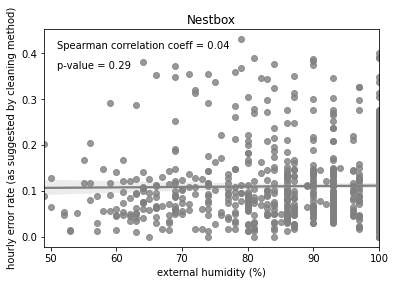

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0, 5)


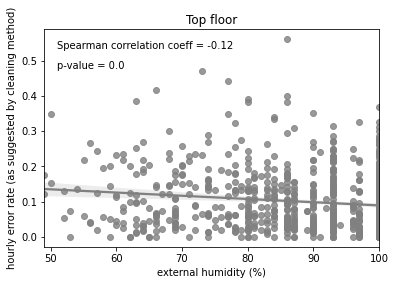

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0, 5)


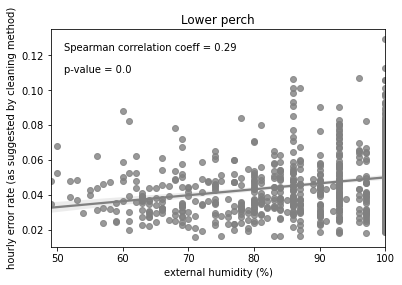

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0, 5)


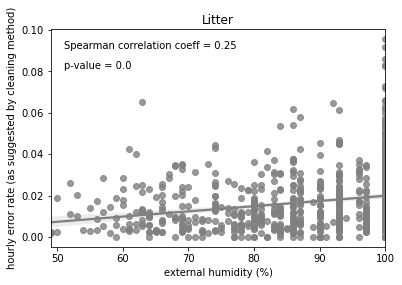

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0, 5)


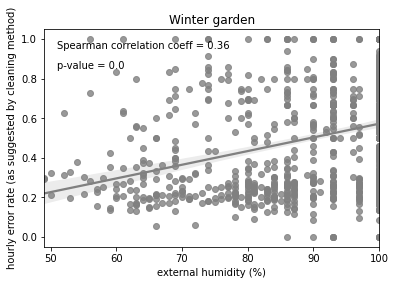

In [10]:
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

#prediction per records
df_pred = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, id_run+name_method+'_Rawdata&Model.csv'), sep=';', 
                 parse_dates=['Timestamp','date'], dayfirst=True)
df_pred.rename(columns={'Trackingsystem_Zone':'Zone'}, inplace=True)
df_pred = df_pred.sort_values('Timestamp') 
print(df_pred.shape)
display(df_pred.head(3))
print(min(df_pred['Timestamp']), max(df_pred['Timestamp']))

#merge it to closest date
df_pred_weather = pd.merge_asof(df_pred, df_weather_h, on='Timestamp')
df_pred_weather['is_day'] = df_pred_weather['Timestamp'].map(lambda x: is_day(x, config.dico_night_hour))
display(df_pred_weather.tail(3))

#visuals
for z in df_pred_weather['Zone'].unique():
    df_humidity_bias = df_pred_weather[(df_pred_weather['Zone']==z)&\
                                       (df_pred_weather['is_day'])].groupby(['Timestamp_weather'])[['prediction','humidity_avgpercent']].agg(lambda x: list(x)).reset_index()
    df_humidity_bias['rate_remainingrecords'] = df_humidity_bias['prediction'].map(lambda x: Counter(list(x))[0]/len(x))
    df_humidity_bias['humidity_avgpercent'] = df_humidity_bias['humidity_avgpercent'].map(lambda x: list(set(x)))
    df_humidity_bias['external humidity (%)'] = df_humidity_bias['humidity_avgpercent'].map(lambda x: x[0] if len(x)==1 else 'error')
    print(df_humidity_bias[df_humidity_bias['external humidity (%)']=='error'].shape)
    #display(df_humidity_bias.head(3))

    #bias toward higher humuditfy?
    ax = sns.regplot('external humidity (%)','rate_remainingrecords', data=df_humidity_bias, color='grey');
    coeff,pval = spearmanr(df_humidity_bias['external humidity (%)'].tolist(), df_humidity_bias['rate_remainingrecords'].tolist())
    #mi = min(df_humidity_bias['rate_remainingrecords'])
    ma = max(df_humidity_bias['rate_remainingrecords'])
    #ax.text(min(df_humidity_bias['external humidity (%)'])+2, mi+0.09*(ma-mi), 'Spearman correlation coeff = ' + str(np.round(coeff,2)))
    #ax.text(min(df_humidity_bias['external humidity (%)'])+2, mi+0.02*(ma-mi), 'p-value = ' + str(np.round(pval,2)))
    ax.text(min(df_humidity_bias['external humidity (%)'])+2, ma*0.95, 'Spearman correlation coeff = ' + str(np.round(coeff,2)))
    ax.text(min(df_humidity_bias['external humidity (%)'])+2, ma*0.85, 'p-value = ' + str(np.round(pval,2)))
    plt.title(config.dico_zone_plot_name[z])
    #plt.ylim(0,1.1)
    #plt.ylabel('hourly rate of non-filtered records')
    plt.ylabel('hourly error rate (as suggested by cleaning method)')
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_'+z+"_humidity_bias.png"),
                dpi=300,format='png',bbox_inches='tight')
    plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


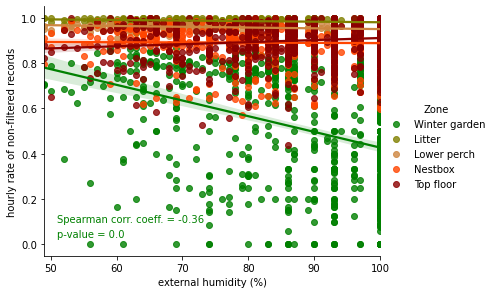

In [63]:
#all together
df_humidity_bias = df_pred_weather[(df_pred_weather['is_day'])].groupby(['Timestamp_weather','Zone'])[['prediction','humidity_avgpercent']].agg(lambda x: list(x)).reset_index()
df_humidity_bias['rate_remainingrecords'] = df_humidity_bias['prediction'].map(lambda x: Counter(list(x))[1]/len(x))
df_humidity_bias['humidity_avgpercent'] = df_humidity_bias['humidity_avgpercent'].map(lambda x: list(set(x)))
df_humidity_bias['external humidity (%)'] = df_humidity_bias['humidity_avgpercent'].map(lambda x: x[0] if len(x)==1 else 'error')
df_humidity_bias['Zone'] = df_humidity_bias['Zone'].map(lambda x: config.dico_zone_plot_name[x])
sns.lmplot('external humidity (%)','rate_remainingrecords', hue='Zone', height=4, aspect=8/6, data=df_humidity_bias, 
           palette=config.pal_zone);
plt.ylabel('hourly rate of non-filtered records')
#add info of WG
df_humidity_bias = df_pred_weather[(df_pred_weather['Zone']=='1_Zone')&\
                                   (df_pred_weather['is_day'])].groupby(['Timestamp_weather'])[['prediction','humidity_avgpercent']].agg(lambda x: list(x)).reset_index()
df_humidity_bias['rate_remainingrecords'] = df_humidity_bias['prediction'].map(lambda x: Counter(list(x))[1]/len(x))
df_humidity_bias['humidity_avgpercent'] = df_humidity_bias['humidity_avgpercent'].map(lambda x: list(set(x)))
df_humidity_bias['external humidity (%)'] = df_humidity_bias['humidity_avgpercent'].map(lambda x: x[0] if len(x)==1 else 'error')
coeff,pval = spearmanr(df_humidity_bias['external humidity (%)'].tolist(), df_humidity_bias['rate_remainingrecords'].tolist())
plt.text(min(df_humidity_bias['external humidity (%)'])+2, max(df_humidity_bias['rate_remainingrecords'])*0.10, 
         'Spearman corr. coeff. = ' + str(np.round(coeff,2)), color=config.pal_zone['Wintergarden'])
plt.text(min(df_humidity_bias['external humidity (%)'])+2, max(df_humidity_bias['rate_remainingrecords'])*0.03, 
         'p-value = ' + str(np.round(pval,2)),  color=config.pal_zone['Wintergarden'])
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_humidity_bias.png'),
                dpi=300,format='png',bbox_inches='tight')
plt.show()

# Generate dataframe for modelling in R

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,level,type,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
1,hen_131,Pen 10,2020-11-14,cleaning,2.0,18.0,20.0,7.0,4.0
2,hen_131,Pen 10,2020-11-15,cleaning,0.0,12.0,16.0,7.0,4.0
3,hen_131,Pen 10,2020-11-16,cleaning,0.0,10.0,12.0,2.0,2.0


,level,HenID,PenID,type,Trackingsystem_Zone,nbr_of_stay
0,2020-11-14,hen_131,Pen 10,cleaning,nbr_stays_1_Zone,2.0
1,2020-11-15,hen_131,Pen 10,cleaning,nbr_stays_1_Zone,0.0
2,2020-11-16,hen_131,Pen 10,cleaning,nbr_stays_1_Zone,0.0


(3189, 9) (40461, 9)
(43650, 9)
(40461, 9)


type,level,HenID,PenID,Trackingsystem_Zone,cleaning,raw,Difference_r-cl,absolute_difference,diff_rate
1,2020-11-13,hen_147,Pen 8,nbr_stays_2_Zone,24.0,25.0,1.0,1.0,0.960000
2,2020-11-13,hen_147,Pen 8,nbr_stays_3_Zone,27.0,36.0,9.0,9.0,0.750000
3,2020-11-13,hen_147,Pen 8,nbr_stays_4_Zone,4.0,12.0,8.0,8.0,0.333333


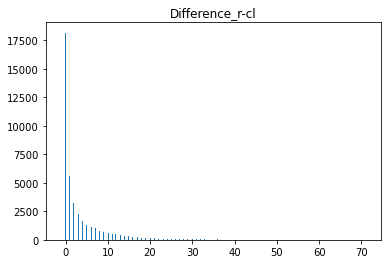

------------------------keep hens that have more than 54 days...
(40461, 9) (35792, 9)


,HenID,level,has_more_xdays
0,hen_1,56,True
1,hen_10,56,True
2,hen_100,9,False


57
number of hens involved: 140
(35792, 9)


type,level,HenID,PenID,Trackingsystem_Zone,cleaning,raw,Difference_r-cl,absolute_difference,diff_rate
1,2020-11-13,hen_147,Pen 8,nbr_stays_2_Zone,24.0,25.0,1.0,1.0,0.960000
2,2020-11-13,hen_147,Pen 8,nbr_stays_3_Zone,27.0,36.0,9.0,9.0,0.750000
3,2020-11-13,hen_147,Pen 8,nbr_stays_4_Zone,4.0,12.0,8.0,8.0,0.333333


In [64]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
display(df_var[['HenID','PenID','level', 'type']+li_var].head(3))
#put all bouts into a columns
df_modelling = pd.melt(df_var, id_vars=['level', 'HenID', 'PenID', 'type'], value_vars=li_var)
df_modelling.rename(columns={'variable':'Trackingsystem_Zone', 'value':'nbr_of_stay'}, inplace=True)
display(df_modelling.head(3))
df_modelling = df_modelling.pivot(index=['level','HenID','PenID','Trackingsystem_Zone'], 
                      columns='type',values='nbr_of_stay').reset_index()
df_modelling['Difference_r-cl'] = df_modelling.apply(lambda x: x['raw']-x['cleaning'], axis=1)
df_modelling['absolute_difference'] = df_modelling['Difference_r-cl'].map(lambda x: abs(x))
#if the tracking system do not record any trnasitions in a zone over a day for a particular animal, then there is nothing to be
#compared, we will remove it simply
df_modelling['diff_rate'] = df_modelling.apply(lambda x: min(x['cleaning'],x['raw'])/max(x['cleaning'],x['raw']) if x['raw']!=0 else np.nan, axis=1)
print(df_modelling[df_modelling['diff_rate'].isnull()].shape, df_modelling[~df_modelling['diff_rate'].isnull()].shape)
#df_modelling['level_continuous'] = df_modelling['level'].map(lambda x: (x-df_modelling['level'].min()).days)
#display(df_modelling[df_modelling['Difference_r-cl']<0]) #checked manually: was correct: when the model remove the last transtion of the 
#night, then the bird will start his day / first stay in a different zone, which at the end can be adding a stay in this zone.
print(df_modelling.shape)
df_modelling = df_modelling[~df_modelling.isnull().any(axis=1)]
print(df_modelling.shape)
display(df_modelling.head(3))
#plot
plt.hist(df_modelling['Difference_r-cl'].dropna(),bins='auto');
plt.title('Difference_r-cl')
plt.show()

print('------------------------keep hens that have more than 54 days...')
df_ = df_modelling.groupby(['HenID'])['level'].agg(lambda x: len(set(x))).reset_index()
#display(df_['level'].value_counts())
df_['has_more_xdays'] = df_['level'].map(lambda x: x>=54)
li_hen2keep = df_[df_['has_more_xdays']]['HenID'].unique()
print(df_modelling.shape, df_modelling[df_modelling['HenID'].isin(li_hen2keep)].shape)
df_modelling = df_modelling[df_modelling['HenID'].isin(li_hen2keep)]
display(df_.head(3))
print(len(df_modelling['level'].unique()))
print('number of hens involved: %d'%len(df_modelling['HenID'].unique()))
print(df_modelling.shape)
display(df_modelling.head(3))

#save
li_modelVAR =  ['absolute_difference', 'diff_rate', 'PenID','Trackingsystem_Zone','HenID','level','humidity_avgpercent']
df_modelling.filter(li_modelVAR).to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                               name_method+'_df4DifferenceModelling.csv'), index=False, sep=';')

### visual per pen

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


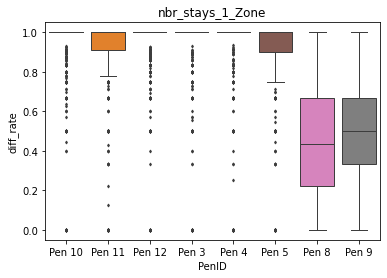

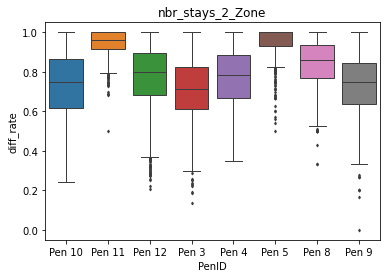

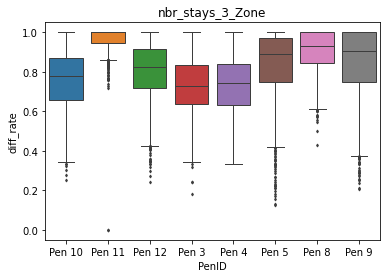

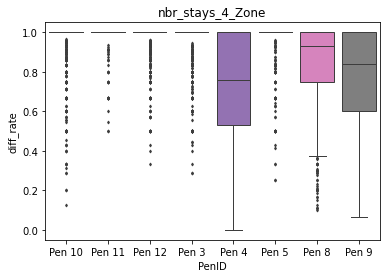

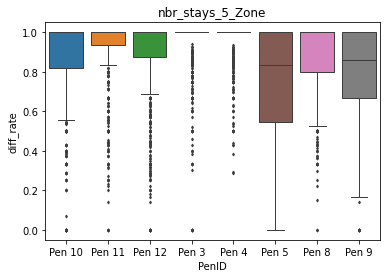

In [65]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_var:
    sns.boxplot(x='PenID', y='diff_rate', data=df_modelling[df_modelling['Trackingsystem_Zone']==v].sort_values('PenID'), 
                fliersize=2, linewidth=1)
    plt.title(v)
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_perPen_'+v+"_diffrate.png"),
            dpi=300,format='png',bbox_inches='tight')
    plt.show()

### Scatter plot: per zone, per pens OVER ENTIRE PERIOD

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


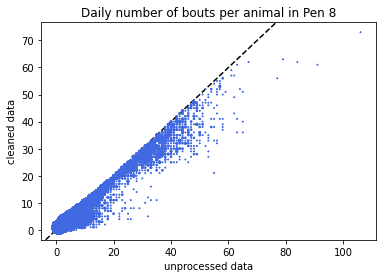

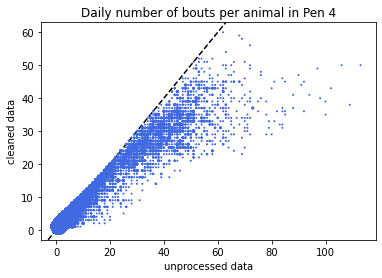

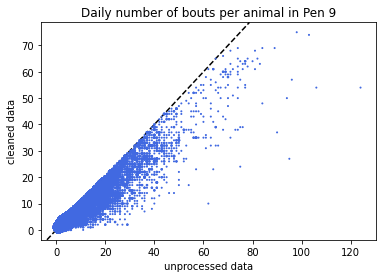

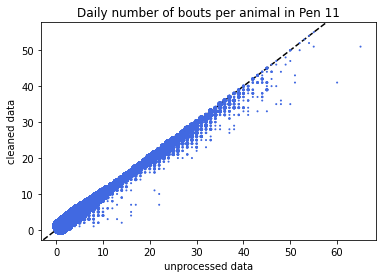

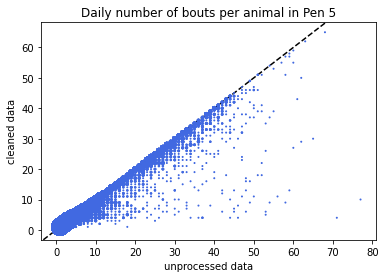

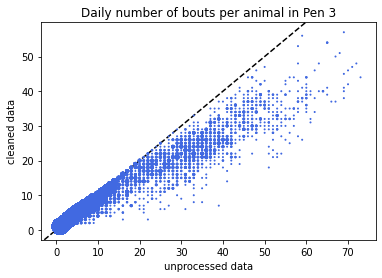

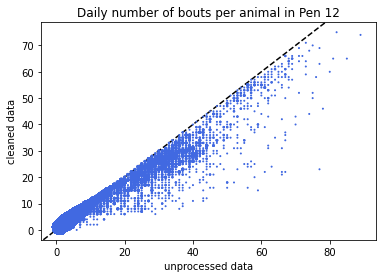

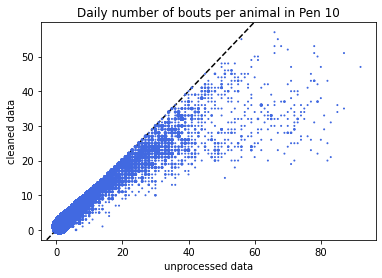

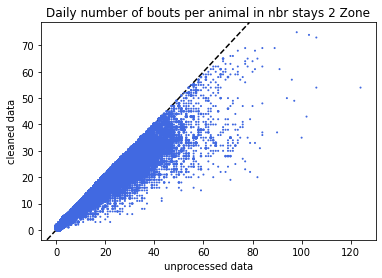

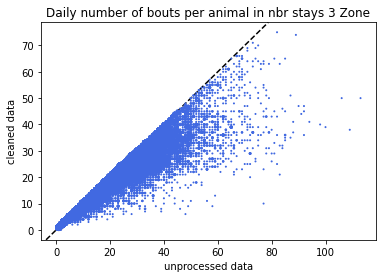

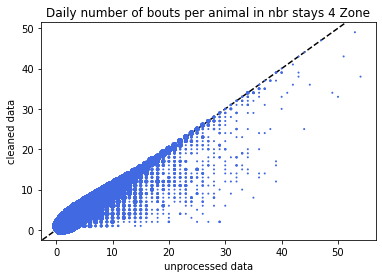

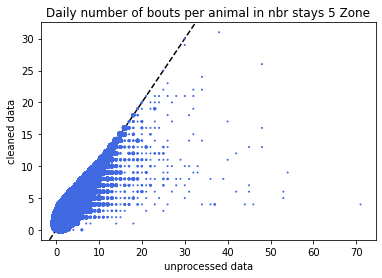

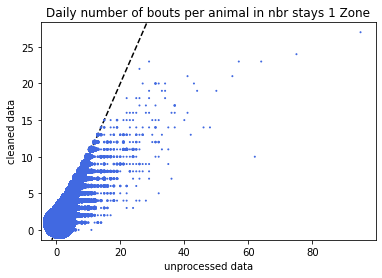

In [66]:
#visuals of the actual number of bouts per methods for curiosity/better understanding
for type_ in ['PenID','Trackingsystem_Zone']:
    for y_ in df_modelling[type_].unique():
        x = np.array(df_modelling[df_modelling[type_]==y_]['raw'].tolist())
        y = np.array(df_modelling[df_modelling[type_]==y_]['cleaning'].tolist())
        c = Counter(zip(x,y))
        # create a list of the sizes, here multiplied by 10 for scale
        s = [1*c[(xx,yy)] for xx,yy in zip(x,y)]
        plt.scatter(x, y, s=s, color = 'royalblue')
        plt.xlabel('unprocessed data')
        plt.ylabel('cleaned data')
        plt.title('Daily number of bouts per animal in '+y_.replace('_',' '))
        #add diagonal line
        plt.axline((0, 0), slope=1, c="black", ls="--", zorder=0)
        #save and show
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+"_NbrStay_"+y_+".png"),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show();

# EV per zones, per pens

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type,PenID,Trackingsystem_Zone,cleaning,raw,EV
0,Pen 10,nbr_stays_1_Zone,"[2.0, 9.0, 7.0, 1.0, 4.0, 1.0, 6.0, 3.0, 3.0, ...","[3.0, 10.0, 8.0, 1.0, 4.0, 1.0, 6.0, 5.0, 3.0,...",0.948616
1,Pen 10,nbr_stays_2_Zone,"[18.0, 23.0, 25.0, 9.0, 28.0, 19.0, 19.0, 3.0,...","[21.0, 30.0, 28.0, 12.0, 31.0, 19.0, 22.0, 4.0...",0.617873
2,Pen 10,nbr_stays_3_Zone,"[20.0, 22.0, 27.0, 11.0, 30.0, 17.0, 22.0, 4.0...","[23.0, 27.0, 31.0, 12.0, 32.0, 18.0, 25.0, 6.0...",0.634785


Trackingsystem_Zone,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
PenID,,,,,
Pen 10,0.948616,0.617873,0.634785,0.973902,0.878513
Pen 11,0.917807,0.954477,0.965586,0.996506,0.738676
Pen 12,0.964528,0.768390,0.803075,0.987113,0.617752
Pen 3,0.943337,0.818532,0.796720,0.970455,0.862372
Pen 4,0.966906,0.684115,0.610798,0.736245,0.922506
Pen 5,0.910346,0.980649,0.710244,0.987951,0.322370
Pen 8,0.470719,0.901677,0.926879,0.742763,0.813360
Pen 9,0.607200,0.840418,0.854320,0.732502,0.765295


[[0.94861588 0.61787294 0.63478471 0.9739016  0.87851267]
 [0.91780689 0.9544765  0.96558562 0.99650579 0.73867585]
 [0.96452754 0.76838953 0.80307459 0.98711334 0.61775207]
 [0.94333693 0.81853246 0.79672046 0.97045515 0.8623724 ]
 [0.96690585 0.68411484 0.6107983  0.7362449  0.92250616]
 [0.91034591 0.98064904 0.71024432 0.9879506  0.32237027]
 [0.47071866 0.90167734 0.92687877 0.74276308 0.81336003]
 [0.60719981 0.84041801 0.85432009 0.73250171 0.76529512]]


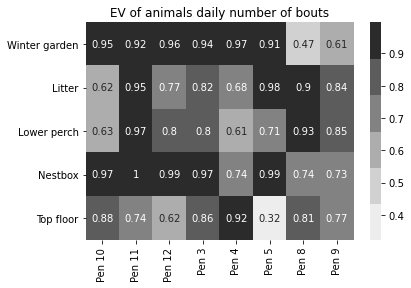

In [73]:
df_quantitatif = df_modelling.groupby(['PenID','Trackingsystem_Zone'])[['cleaning','raw']].agg(lambda x: list(x)).reset_index()
df_quantitatif['EV'] = df_quantitatif.apply(lambda x: explained_variance_score(x['raw'], x['cleaning']), axis=1)
display(df_quantitatif.head(3))
df_quantitatif = df_quantitatif.pivot(values='EV',index='PenID',columns='Trackingsystem_Zone')
display(df_quantitatif)
M = df_quantitatif.to_numpy()
dico_x_name = {'nbr_stays_1_Zone':'Winter garden',
                 'nbr_stays_2_Zone':'Litter',
                 'nbr_stays_3_Zone':'Lower perch',
                 'nbr_stays_4_Zone':'Nestbox',
                 'nbr_stays_5_Zone':'Top floor'}
print(M)
sns.heatmap(M.transpose(), xticklabels=df_quantitatif.index.tolist(), 
            yticklabels=[dico_x_name[x] for x in df_quantitatif.columns.tolist()], cmap=sns.color_palette("Greys"),
           annot=True)
plt.title('EV of animals daily number of bouts')
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_EV_ZonePerPen.png'),format='png',dpi=300,
           bbox_inches='tight')
plt.show()

# EV per hens, active hens bias?

In [68]:
df_quantitatif_hen = df_modelling.groupby(['HenID'])[['cleaning','raw']].agg(lambda x: list(x)).reset_index()
df_quantitatif_hen['EV'] = df_quantitatif_hen.apply(lambda x: explained_variance_score(x['raw'], x['cleaning']), axis=1)
df_quantitatif_hen['average number of bouts in a zone'] = df_quantitatif_hen['cleaning'].map(lambda x: np.mean(x))
df_quantitatif_hen

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type,HenID,cleaning,raw,EV,average number of bouts in a zone
0,hen_1,"[8.0, 17.0, 9.0, 4.0, 5.0, 4.0, 13.0, 9.0, 2.0...","[8.0, 17.0, 9.0, 4.0, 5.0, 7.0, 17.0, 10.0, 2....",0.663893,12.035714
1,hen_10,"[2.0, 13.0, 13.0, 4.0, 3.0, 3.0, 16.0, 15.0, 5...","[2.0, 13.0, 13.0, 4.0, 3.0, 3.0, 16.0, 15.0, 5...",0.974926,11.233202
2,hen_101,"[7.0, 15.0, 14.0, 8.0, 10.0, 16.0, 11.0, 7.0, ...","[7.0, 16.0, 14.0, 9.0, 11.0, 18.0, 11.0, 8.0, ...",0.965716,14.917323
3,hen_102,"[3.0, 5.0, 7.0, 9.0, 6.0, 1.0, 3.0, 5.0, 6.0, ...","[3.0, 7.0, 9.0, 9.0, 6.0, 1.0, 3.0, 5.0, 6.0, ...",0.937334,9.118519
4,hen_105,"[1.0, 8.0, 10.0, 5.0, 5.0, 4.0, 7.0, 7.0, 6.0,...","[2.0, 9.0, 14.0, 9.0, 5.0, 6.0, 8.0, 8.0, 8.0,...",0.831345,10.163636
...,...,...,...,...,...
135,hen_95,"[3.0, 22.0, 24.0, 10.0, 5.0, 19.0, 24.0, 9.0, ...","[5.0, 24.0, 24.0, 10.0, 5.0, 19.0, 24.0, 9.0, ...",0.987551,12.494505
136,hen_96,"[9.0, 14.0, 6.0, 7.0, 8.0, 12.0, 4.0, 4.0, 7.0...","[12.0, 17.0, 7.0, 7.0, 9.0, 13.0, 5.0, 5.0, 8....",0.844631,9.612903
137,hen_97,"[3.0, 6.0, 7.0, 5.0, 6.0, 8.0, 7.0, 6.0, 4.0, ...","[4.0, 7.0, 7.0, 5.0, 6.0, 8.0, 7.0, 6.0, 5.0, ...",0.552048,8.709677
138,hen_98,"[0.0, 5.0, 6.0, 8.0, 8.0, 1.0, 6.0, 7.0, 6.0, ...","[1.0, 6.0, 6.0, 8.0, 8.0, 2.0, 8.0, 7.0, 6.0, ...",0.762065,6.924242


In [69]:
#extreme case verified : a lot of flickering
min(df_quantitatif_hen['EV']), max(df_quantitatif_hen['EV']), np.median(df_quantitatif_hen['EV'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.15554978357861438, 0.9945982435525974, 0.8934240126887556)

In [70]:
df_quantitatif_hen[df_quantitatif_hen['EV']==min(df_quantitatif_hen['EV'])]
#df_modelling[df_modelling['HenID']=='hen_12'].iloc[0:50]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type,HenID,cleaning,raw,EV,average number of bouts in a zone
16,hen_12,"[14.0, 33.0, 22.0, 7.0, 4.0, 8.0, 14.0, 9.0, 6...","[15.0, 34.0, 28.0, 7.0, 10.0, 9.0, 15.0, 23.0,...",0.15555,6.938224


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


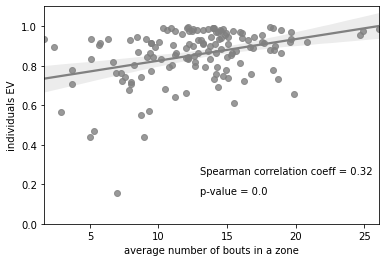

In [76]:
#bias toward more active birds?
ax = sns.regplot('average number of bouts in a zone','EV', data=df_quantitatif_hen, color='grey');
coeff,pval = spearmanr(df_quantitatif_hen['average number of bouts in a zone'].tolist(), df_quantitatif_hen['EV'].tolist())
ax.text(13, 0.25, 'Spearman correlation coeff = ' + str(np.round(coeff,2)))
ax.text(13, 0.15, 'p-value = ' + str(np.round(pval,2)))
plt.ylim(0,1.1)
plt.ylabel('individuals EV')
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+"_activehens_bias.png"),
            dpi=300,format='png',bbox_inches='tight')
plt.show()

# Difference of behavioural variables

In [20]:
#display(list((df_var.columns)))
df_var[['night_Total_number_transition', 'Total_number_transition', 'is_mvt_night', 'skew_duration']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,night_Total_number_transition,Total_number_transition,is_mvt_night,skew_duration
1,0.0,50.0,0.0,1.327357
2,0.0,38.0,0.0,1.425021
3,0.0,25.0,0.0,0.945491


In [21]:
#define color of the hen depending on the median of it total nbr of transition over the overall period
#a variables that cant be controlled thorugh video bservation (night)
#an important variables: vertical_travel_distance
#a more complex variables: kurtosis_duration, skew_duration, 
#other incase: in_WG_15mnAfterOpening, vertical_travel_distance, activity_95percentile_sec
li_v = ['night_Total_number_transition', 'Total_number_transition', 'is_mvt_night', 'skew_duration']
li_df = []
for y_ in li_v:  
    #data: one colomn for the raw and one for the cleaned
    df_plt = df_var[['HenID','level', 'type', y_]].copy()
    df_plt = df_plt.pivot(index=['HenID','level'], columns='type',values=y_).reset_index()
    #print(df_plt.shape)
    df_plt = df_plt[~df_plt.isnull().any(axis=1)]
    #print(df_plt.shape)
    #display(df_plt.head(3))        
    x = np.array(df_plt['raw'].tolist())
    y = np.array(df_plt['cleaning'].tolist())

    #measures
    Explvarscore = explained_variance_score(x, y)
    RMSE = math.sqrt(mean_squared_error(x, y))
    MADIF = mean_absolute_error(x, y)
    li_df.append({'variable':y_, 'Explvarscore':Explvarscore, 'RMSE':RMSE, 'MADIF':MADIF})
df_res = pd.DataFrame(li_df)
df_res.to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,name_method+'_BehaviouralVariablesDifferences.csv'), sep=';', 
              index=False)
df_res

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,variable,Explvarscore,RMSE,MADIF
0,night_Total_number_transition,0.247011,12.821667,1.439908
1,Total_number_transition,0.762084,23.233577,15.571821
2,is_mvt_night,0.910862,0.144886,0.020992
3,skew_duration,0.860663,0.588849,0.388923


# Visualise the MLP's differences

#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, id_run+name_method+'_Rawdata&Model.csv'), sep=';', 
                 parse_dates=['Timestamp','date'], dayfirst=True) 
print(df.shape)
df.head(3)

START_TIME = time.perf_counter()
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,11,13)
dmax = dt.datetime(2020,11,22)
#df_ = df[(df['date']<dt.datetime(2020,11,16))&(df['date']>dt.datetime(2020,11,10))]
df_ = df[(df['date']<=dmax)&(df['date']>=dmin)].copy()
#only print the hens with at least one transition per day (simplicity and interestignly)
#to sort the yaxis
dico_zone_order = {'1_Zone':0, '2_Zone':1, '3_Zone':2, '4_Zone':3, '5_Zone':4}
li_ts = ['Trackingsystem_Zone','Model_Zone']
li_date = df_['date'].unique()
#for each batch draw 2 timeseries, the raw one and the model one
for henID, df_plt in tqdm.tqdm(df_.groupby(['HenID'])):
    df_plt = df_plt.sort_values(['Timestamp']).copy()
    c = len(li_ts) ; l = len(li_date)
    fig, ax = plt.subplots(figsize=(c*5, l*1))
    i = 1
    if len(df_plt['date'].unique())==len(li_date):
        mi = min(df_plt['Timestamp'].tolist()) ; ma = max(df_plt['Timestamp'].tolist())
        Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                                  end = ma-dt.timedelta(seconds=(ma.second+1)), 
                                  freq = 'S') 
        df_plt_ = df_plt.copy()
        df_plt_.set_index('Timestamp', inplace=True)
        df_plt_ = df_plt_.reindex(Daterange, method='ffill').reset_index()
        df_plt_.rename(columns={'index':'Timestamp'}, inplace=True)
        #add date again, as the reindexing also extended the date
        df_plt_['date'] = df_plt_['Timestamp'].map(lambda x: dt.datetime.date(x))
        #remove first & last date
        df_plt_ = df_plt_[~df_plt_['date'].isin([max(df_plt_['date'].tolist()),min(df_plt_['date'].tolist())])]
        #put xlabel into numbers for the ploting
        df_plt_['Trackingsystem_Zone'] = df_plt_['Trackingsystem_Zone'].map(lambda x: int(dico_zone_order[x]))       
        for d, df_plt__ in df_plt_.groupby(['date']):
            for v in li_ts:
                df_plt___ = df_plt__.copy()
                if v=='Model_Zone':
                    df_plt___ = df_plt___[df_plt___['prediction']==1]
                plt.subplot(l,c,i)
                plt.tight_layout(pad=0.3) #add spacing between each plot
                if i%2==1:
                    plt.yticks([0,1,2,3,4], ['Winter garden', 'Litter', 'Lower perch','Nestbox','Top floor'])#, rotation='vertical')
                else:
                    plt.yticks([0,1,2,3,4], ['','','','',''])
                if i in [1,2]:
                    plt.title(v.replace('_',' '), size=13)
                i = i+1
                plt.plot(df_plt___['Timestamp'].tolist(), df_plt___['Trackingsystem_Zone'].tolist(), 
                         color=pal_[v], linewidth=1)
                li_hour = pd.date_range(start = d,  end = d+dt.timedelta(days=1), freq = 'H')
                plt.xticks(li_hour , [str(i.hour)+'h' for i in li_hour], fontsize=5)                
                plt.yticks(fontsize=8)
                plt.xlabel(str(d).split('T')[0], size=7)
                plt.ylim(0, 4.2)  
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned_MLP,
                                 name_method+'_'+henID+'_'+str(dmin).split(' ')[0]+'_'+str(dmax).split(' ')[0]+'.png'), 
                    format='png', bbox_inches='tight', dpi=300)
    plt.clf()
    plt.close("all")    
END_TIME = time.perf_counter()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
#hen4, 22.10.2020: flickering. solved?